## CV → TruCV AI Parsing Prototype (Laboratory)

### Input: Resume (PDF / DOCX)

- Output: TruCV Draft JSON + confidence + warnings

- Uses: OpenAI API

### Does NOT handle:

- Verification

- Blockchain

- Database writes

- Auth

##  Step 1 — Imports & Global Config

In [57]:

#Core Python
import os
import json
import uuid
from typing import TypedDict, Literal, Dict, Any, List, Optional, Annotated
import operator
from dotenv import load_dotenv

#File parsing 
from docx import Document
import pypdf

#Orchistration
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

#Pydantic
from pydantic import BaseModel, Field, ValidationError

import uuid
import json

In [58]:
load_dotenv()

True

In [ ]:
# For better Accuracy
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=6000
)

# Fast Tier (For Router/Skills/Awards/Personal)
llm_fast = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0,
    max_tokens=6000
)

In [60]:
#global veriable 
CONFIDENCE_THRESHOLD = 0.65
MAX_RETRIES_PER_SECTION = 1

SUPPORTED_SECTIONS = [
    "personal",
    "education",
    "experience",
    "skills",
    "projects",
    "awards"
]

## Step 2 — TruCV Target Schema (CRITICAL)

In [61]:
#0 . Common / Reusable Models

class TruCVBaseModel(BaseModel):
    class Config:
        populate_by_name = True
        extra = "ignore"

# from is a Python keyword → use from_ + alias="from"
class Duration(TruCVBaseModel):
    from_: Optional[str] = Field(None, alias="from")
    to: Optional[str] = None

#1 . Personal Section
class PersonalInfo(TruCVBaseModel):
    fullName: Optional[str] = None
    email: Optional[str] = None
    phone: Optional[str] = None
    city: Optional[str] = None
    linkedin: Optional[str] = None
    github: Optional[str] = None
    summary: Optional[str] = None
    imgUrl: Optional[str] = None

#2. Education Model
class Education(TruCVBaseModel):
    id: Optional[str] = None
    eduDocId: Optional[str] = None 
    level: Optional[str] = None
    boardNameOrDegree: Optional[str] = None
    institutionName: Optional[str] = None
    gpa: Optional[str] = None
    duration: Optional[Duration] = None

    selfAttested: bool = True
    docUri: Optional[str] = None
    issuerEmailId: Optional[str] = ""
    isEmailSend: bool = False

    verified: bool = False
    status: Literal["pending", "verified"] = "pending"


#3. Experience Model
class Experience(TruCVBaseModel):
    id: Optional[str] = None
    companyName: Optional[str] = None
    jobRole: Optional[str] = None
    duration: Optional[Duration] = None
    skills: Optional[str] = None # AI must format this as comma-separated string
    description: Optional[str] = None

    selfAttested: bool = True
    isEmailSend: bool = False
    docUri: Optional[str] = None
    issuerEmailId: Optional[str] = ""

    verified: bool = False
    status: Literal["pending", "verified"] = "pending"

#4. Skills Model
class Skill(TruCVBaseModel):
    id: Optional[str] = None
    skillName: Optional[str] = None
    level: Optional[str] = None

    selfAttested: bool = True
    endoresBy: Optional[str] = ""
    endoresThrough: Optional[str] = ""

#5. Project Model
class Project(TruCVBaseModel):
    id: Optional[str] = None
    projectName: Optional[str] = None
    projectUrl: Optional[str] = None
    duration: Optional[Duration] = None
    skills: Optional[str] = None
    description: Optional[str] = None

    selfAttested: bool = True

#6. Award / Certificate Model
class Award(TruCVBaseModel):
    id: Optional[str] = None
    level: Optional[str] = None
    name: Optional[str] = None
    organisation: Optional[str] = None
    duration: Optional[Duration] = None
    description: Optional[str] = None

    selfAttested: bool = True
    issuerEmailId: Optional[str] = ""
    docUri: Optional[str] = ""
    isEmailSend: bool = False

    verified: bool = False
    # 🛠️ FIXED: Removed "rejected"
    status: Literal["pending", "verified"] = "pending"

# Final TruCV Root Model
class TruCVDraft(TruCVBaseModel):
    userId: Optional[str] = None
    title: Optional[str] = None

    personal: PersonalInfo

    educations: List[Education] = Field(default_factory=list)
    experiences: List[Experience] = Field(default_factory=list)
    skills: List[Skill] = Field(default_factory=list)
    projects: List[Project] = Field(default_factory=list)
    awards: List[Award] = Field(default_factory=list)

##  Step 3 — Internal AI Parsing Schema (Intermediate)

In [62]:
class ParsedBaseModel(BaseModel):
    class Config:
        extra = "ignore"
 
# 1️. Atomic Parsed Field
class ParsedField(ParsedBaseModel):
    value: Optional[str] = None
    confidence: float = Field(
        ge=0.0,
        le=1.0,
        description="Confidence score between 0 and 1"
    )
#2. Parsed Personal Section
class ParsedPersonal(ParsedBaseModel):
    fullName: Optional[ParsedField] = None
    email: Optional[ParsedField] = None
    phone: Optional[ParsedField] = None
    city: Optional[ParsedField] = None
    linkedin: Optional[ParsedField] = None
    github: Optional[ParsedField] = None
    summary: Optional[ParsedField] = None


#3.Parsed Education
class ParsedEducationEntry(ParsedBaseModel):
    level: Optional[ParsedField] = None
    boardNameOrDegree: Optional[ParsedField] = None
    institutionName: Optional[ParsedField] = None
    gpa: Optional[ParsedField] = None
    duration_from: Optional[ParsedField] = None
    duration_to: Optional[ParsedField] = None

class ParsedEducation(ParsedBaseModel):
    items: List[ParsedEducationEntry] = Field(default_factory=list)
    section_confidence: float = Field(ge=0.0, le=1.0)


#4. Parsed Experience
class ParsedExperienceEntry(ParsedBaseModel):
    companyName: Optional[ParsedField] = None
    jobRole: Optional[ParsedField] = None
    skills: Optional[ParsedField] = None
    description: Optional[ParsedField] = None
    duration_from: Optional[ParsedField] = None
    duration_to: Optional[ParsedField] = None

class ParsedExperience(ParsedBaseModel):
    items: List[ParsedExperienceEntry] = Field(default_factory=list)
    section_confidence: float = Field(ge=0.0, le=1.0)


#5.Parsed Skills 
class ParsedSkillEntry(ParsedBaseModel):
    skillName: Optional[ParsedField] = None
    level: Optional[ParsedField] = None

class ParsedSkills(ParsedBaseModel):
    items: List[ParsedSkillEntry] = Field(default_factory=list)
    section_confidence: float = Field(ge=0.0, le=1.0)


#6. Parsed Projects
class ParsedProjectEntry(ParsedBaseModel):
    projectName: Optional[ParsedField] = None
    projectUrl: Optional[ParsedField] = None
    skills: Optional[ParsedField] = None
    description: Optional[ParsedField] = None
    duration_from: Optional[ParsedField] = None
    duration_to: Optional[ParsedField] = None

class ParsedProjects(ParsedBaseModel):
    items: List[ParsedProjectEntry] = Field(default_factory=list)
    section_confidence: float = Field(ge=0.0, le=1.0)


#7. Parsed Awards
class ParsedAwardEntry(ParsedBaseModel):
    level: Optional[ParsedField] = None
    name: Optional[ParsedField] = None
    organisation: Optional[ParsedField] = None
    description: Optional[ParsedField] = None
    duration_from: Optional[ParsedField] = None
    duration_to: Optional[ParsedField] = None

class ParsedAwards(ParsedBaseModel):
    items: List[ParsedAwardEntry] = Field(default_factory=list)
    section_confidence: float = Field(ge=0.0, le=1.0)


#8. Parsed Resume
class ParsedResume(ParsedBaseModel):
    personal: Optional[ParsedPersonal] = None
    education: Optional[ParsedEducation] = None
    experience: Optional[ParsedExperience] = None
    skills: Optional[ParsedSkills] = None
    projects: Optional[ParsedProjects] = None
    awards: Optional[ParsedAwards] = None



## Step 4 — Resume Upload (Pdf)

In [63]:
# 1. Define the path to your prototype resume
uploaded_file_path = "/home/ganesh/Desktop/LanChain-Framework/Cv_to_trucv/Hema_resume.pdf" 

# 2. Validation Checks
if not os.path.exists(uploaded_file_path):
    raise FileNotFoundError(f"File not found at: {uploaded_file_path}")

file_ext = os.path.splitext(uploaded_file_path)[1].lower()

if file_ext != ".pdf":
    raise ValueError(f"Unsupported format '{file_ext}'. This prototype strictly requires PDF files.")

print(f"Resume file loaded successfully: {os.path.basename(uploaded_file_path)}")

Resume file loaded successfully: Hema_resume.pdf


## Step5  — Text Extraction Layer (PDF)

### Inputs
- uploaded_file_path

### Outputs
- raw_text
- Metadata Links (URIs)

In [64]:
def extract_content_with_metadata(file_path):
    """
    Extracts raw text and hidden hyperlinks (URIs) from a PDF.
    """
    reader = pypdf.PdfReader(file_path)
    full_text = []
    extracted_links = set()

    # 1. Iterate through pages for text and links
    for page_index, page in enumerate(reader.pages):
        # Extract visible text
        page_text = page.extract_text()
        if page_text:
            full_text.append(page_text)
        
        # Extract hidden 'Annotated' links (URIs) -> catches links embedded in words like "LinkedIn" or "GitHub"
        if "/Annots" in page:
            for annot in page["/Annots"]:
                obj = annot.get_object()
                if "/A" in obj and "/URI" in obj["/A"]:
                    uri = obj["/A"]["/URI"]
                    extracted_links.add(uri)

    # 2. Join the text content
    raw_content = "\n".join(full_text)
    
    # 3. Format the links as a header for the AI to process
    links_str = ", ".join(extracted_links) if extracted_links else "None Found"
    
    # 4. UNIFY: Combine metadata and raw text
    normalized_data = f"--- EMBEDDED_METADATA_LINKS ---\n{links_str}\n\n--- RESUME_CONTENT ---\n{raw_content}"
    
    return normalized_data


In [65]:
normalized_text = extract_content_with_metadata(uploaded_file_path)

## Step 6 — Semantic Section Detection (The "Router")
### Inputs
- normalized_text
### Outputs
- sections = {
    "personal": str,
    "education": str,
    "experience": str,
    "skills": str,
    "projects": str,
    "awards": str
}



In [66]:
# 1. Define the Router Schema (Strict Contract)
class SectionSplit(BaseModel):
    personal: str = Field(description="Raw text containing name, contact, links, summary, and profile image url")
    education: str = Field(description="Raw text containing degrees, universities, dates, and grades")
    experience: str = Field(description="Raw text containing job roles, companies, dates, and responsibilities")
    skills: str = Field(description="Raw text containing technical skills, soft skills, tools, and languages")
    projects: str = Field(description="Raw text containing project names, descriptions, and links")
    awards: str = Field(description="Raw text containing certifications, honors, and achievements")

def detect_sections_semantically(text: str) -> Dict[str, str]:
    print("Detecting sections semantically...")
    
    # 2. System Prompt: The "Router" instructions
    system_prompt = """
    You are an expert Resume Segmenter. 
    Your task is to classify every single line of the provided resume text into one of these 6 buckets:
    - personal
    - education
    - experience
    - skills
    - projects
    - awards

    CRITICAL RULES:
    1. Do not summarize. Copy the EXACT text from the resume into the correct bucket.
    2. METADATA RULE: If the text contains '--- EMBEDDED_METADATA_LINKS ---', you MUST include that entire block inside the 'personal' bucket.
    3. Personal section MUST include the Name, Phone, Email, and all links found at the top.
    4. If a section is missing, return an empty string for that key.
    5. Keep all context: If text is ambiguous, keep it with the most relevant section.
    """
    
    # 3. Use 'with_structured_output' to prevent JSON crashes
    # This forces the LLM to call a function, returning a valid Pydantic object
    router_llm = llm.with_structured_output(SectionSplit)
    
    try:
        response = router_llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"RESUME TEXT:\n{text}")
        ])
        
        # Convert Pydantic model to Python Dict
        sections = response.model_dump()
        return sections

    except Exception as e:
        raise RuntimeError(f"Semantic Section Detection Failed: {str(e)}")


## Step 7 — Section Parsing (AI-Powered)

### Inputs
- sections
### Outputs
- parsed_sections = {
    "personal": {...},
    "education": [...],
    "experience": [...],
    "skills": [...],
    "projects": [...],
    "awards": [...]
}

In [67]:
# GLOBAL INSTRUCTION (Appended to all prompts)
BASE_INSTRUCTION = """
You are a strict data extraction AI for TruCV.
INPUT: Raw text from a resume section.
OUTPUT: Valid JSON matching the exact schema requested.

RULES:
1. DATA STRUCTURE: Every field MUST be an object with {"value": ..., "confidence": ...}.
2. DATES: Format as "YYYY-MM" (e.g., "2023-08"). If currently active, use "Present". 
3. CONFIDENCE: Provide a float (0.0 to 1.0) based on how clearly the data was stated.
4. NO HALLUCINATION: If data is missing, use "value": null and "confidence": 0.0.
5. NO MARKDOWN: Return ONLY raw JSON.
"""


# 1. PERSONAL SECTION (Updated for Embedded Metadata)
PROMPT_PERSONAL = f"""
{BASE_INSTRUCTION}

EXTRACT THESE FIELDS:
- fullName, email, phone, city, summary.
- linkedin: Full URL.
- github: Full URL.

CRITICAL - LINK PRIORITY:
The input text starts with '--- EMBEDDED_METADATA_LINKS ---'. 
1. Scan the URLs in that metadata header first.
2. If you find a LinkedIn or GitHub URL in the metadata, use it for the 'linkedin' and 'github' fields.
3. Only use links from the 'RESUME_CONTENT' if the metadata header is empty.

SCHEMA TARGET:
{{
  "fullName": {{ "value": "...", "confidence": 1.0 }},
  "email": {{ "value": "...", "confidence": 1.0 }},
  "phone": {{ "value": "...", "confidence": 1.0 }},
  "city": {{ "value": "...", "confidence": 1.0 }},
  "linkedin": {{ "value": "...", "confidence": 1.0 }},
  "github": {{ "value": "...", "confidence": 1.0 }},
  "summary": {{ "value": "...", "confidence": 1.0 }}
}}
"""


# 2. EDUCATION SECTION (Optimized for GPT-4o)
PROMPT_EDUCATION = f"""
{BASE_INSTRUCTION}
Extract all educational qualifications.

FIELDS PER ITEM:
- level: MUST be one of ["Grade 10", "Grade 12", "Undergraduate", "Postgraduate", "PhD"].
- boardNameOrDegree: e.g., "BCA Data Science", "CBSE".
- institutionName: College or School name.
- gpa: Extracted exactly as written (e.g., "8.5/10", "82%").
- duration_from / duration_to: YYYY-MM.

SCHEMA TARGET:
{{
  "items": [
    {{
      "level": {{ "value": "Undergraduate", "confidence": 1.0 }},
      "boardNameOrDegree": {{ "value": "...", "confidence": 1.0 }},
      "institutionName": {{ "value": "...", "confidence": 1.0 }},
      "gpa": {{ "value": "...", "confidence": 1.0 }},
      "duration_from": {{ "value": "...", "confidence": 1.0 }},
      "duration_to": {{ "value": "...", "confidence": 1.0 }}
    }}
  ],
  "section_confidence": 1.0
}}
"""


# 3. EXPERIENCE SECTION (Optimized for GPT-4o)
PROMPT_EXPERIENCE = f"""
{BASE_INSTRUCTION}
Extract all professional work history/internships.

FIELDS PER ITEM:
- companyName: Full name of organization.
- jobRole: Your title.
- description: Detailed bullet points of work done.
- skills: Comma-separated string of tech used in this specific role.
- duration_from / duration_to: YYYY-MM.

SCHEMA TARGET:
{{
  "items": [
    {{
      "companyName": {{ "value": "...", "confidence": 1.0 }},
      "jobRole": {{ "value": "...", "confidence": 1.0 }},
      "description": {{ "value": "...", "confidence": 1.0 }},
      "skills": {{ "value": "Python, SQL", "confidence": 1.0 }},
      "duration_from": {{ "value": "...", "confidence": 1.0 }},
      "duration_to": {{ "value": "Present", "confidence": 1.0 }}
    }}
  ],
  "section_confidence": 1.0
}}
"""

# 4. SKILLS SECTION
PROMPT_SKILLS = f"""
{BASE_INSTRUCTION}
Extract technical and soft skills. Categorize level as "Beginner", "Intermediate", or "Expert".

SCHEMA TARGET:
{{
  "items": [
    {{
      "skillName": {{ "value": "...", "confidence": 1.0 }},
      "level": {{ "value": "...", "confidence": 1.0 }}
    }}
  ],
  "section_confidence": 1.0
}}
"""


# 5. PROJECTS SECTION
PROMPT_PROJECTS = f"""
{BASE_INSTRUCTION}
Extract projects. If a project has a link (GitHub/Demo) in the description, extract it to projectUrl.

SCHEMA TARGET:
{{
  "items": [
    {{
      "projectName": {{ "value": "...", "confidence": 1.0 }},
      "projectUrl": {{ "value": "...", "confidence": 1.0 }},
      "description": {{ "value": "...", "confidence": 1.0 }},
      "skills": {{ "value": "...", "confidence": 1.0 }},
      "duration_from": {{ "value": null, "confidence": 0.0 }},
      "duration_to": {{ "value": null, "confidence": 0.0 }}
    }}
  ],
  "section_confidence": 1.0
}}
"""


# 6. AWARDS SECTION
PROMPT_AWARDS = f"""
{BASE_INSTRUCTION}
Extract certifications, honors, and awards.

SCHEMA TARGET:
{{
  "items": [
    {{
      "name": {{ "value": "...", "confidence": 1.0 }},
      "organisation": {{ "value": "...", "confidence": 1.0 }},
      "level": {{ "value": "International", "confidence": 1.0 }},
      "description": {{ "value": "...", "confidence": 1.0 }},
      "duration_from": {{ "value": "...", "confidence": 1.0 }}
    }}
  ],
  "section_confidence": 1.0
}}
"""

## Step 8 — Section Parsing Functions (Pure & Stateless)

In [68]:
def _fetch_parsed_data(section_name: str, text: str, model_schema: Any, prompt: str, high_accuracy: bool = False) -> Any:
    if not text or len(text.strip()) < 10:
        return model_schema(section_confidence=0.0)
    
    # Select LLM 
    selected_llm = llm if high_accuracy else llm_fast
    
    print(f"Parsing {section_name.upper()} ({'Accurate' if high_accuracy else 'Fast'} Tier)...")
    
    structured_llm = selected_llm.with_structured_output(model_schema)
    
    try:
        response = structured_llm.invoke([
            SystemMessage(content=prompt),
            HumanMessage(content=f"SECTION TEXT:\n{text}")
        ])
        return response
    except Exception as e:
        print(f" Error in {section_name}: {e}")
        return model_schema(section_confidence=0.0)
    
# 1. Personal
def parse_personal(text: str) -> ParsedPersonal:
    return _fetch_parsed_data("personal", text, ParsedPersonal, PROMPT_PERSONAL)

# 2. Education
def parse_education(text: str) -> ParsedEducation:
    return _fetch_parsed_data("education", text, ParsedEducation, PROMPT_EDUCATION, high_accuracy=True)

# 3. Experience
def parse_experience(text: str) -> ParsedExperience:
    return _fetch_parsed_data("experience", text, ParsedExperience, PROMPT_EXPERIENCE,high_accuracy=True)

# 4. Skills
def parse_skills(text: str) -> ParsedSkills:
    return _fetch_parsed_data("skills", text, ParsedSkills, PROMPT_SKILLS)

# 5. Projects
def parse_projects(text: str) -> ParsedProjects:
    return _fetch_parsed_data("projects", text, ParsedProjects, PROMPT_PROJECTS)

# 6. Awards
def parse_awards(text: str) -> ParsedAwards:
    return _fetch_parsed_data("awards", text, ParsedAwards, PROMPT_AWARDS)

## Step 9 — LangGraph State Definition

In [69]:
class GraphState(TypedDict):
    # 1. RAW INPUTS
    raw_text: str                   
    
    # 2. INTERMEDIATE (The "Router" Output)
    sections: Dict[str, str]        
    
    # 3. AI PARSING RESULTS
    ''''We use Optional so they can be None initially.
    In a parallel graph, these will be updated by individual nodes.
    '''
    personal: Optional[ParsedPersonal]
    education: Optional[ParsedEducation]
    experience: Optional[ParsedExperience]
    skills: Optional[ParsedSkills]
    projects: Optional[ParsedProjects]
    awards: Optional[ParsedAwards]
    
    # 4. ORCHESTRATION & CONTROL
    '''Annotated[..., operator.add] allows multiple nodes to add to this list,
    without overwriting previous errors.
    '''
    errors: Annotated[List[str], operator.add] 
    
    # We use a dict for confidence so we can see the score per section
    confidence_map: Dict[str, float] 
    
    # 5. FINAL OUTPUT
    '''This will be the structured JSON matching TruCV's MongoDB schema'''
    trucv_draft: Optional[Dict[str, Any]] 

    # 6. METADATA
    '''To track if we used metadata links or raw text for personal info'''
    metadata_used: bool

## Step 10 — Confidence Scoring Engine

In [70]:
def calculate_personal_score(personal: ParsedPersonal) -> (float, List[str]):
    """Calculates weighted confidence for Personal section."""
    score = 1.0
    warnings = []
    
    # CRITICAL FIELDS (Heavy Penalty)
    if not personal.fullName.value:
        score -= 0.4
        warnings.append("CRITICAL: Name is missing.")
    if not personal.email.value:
        score -= 0.3
        warnings.append("CRITICAL: Email is missing.")
    if not personal.phone.value:
        score -= 0.1
        warnings.append("WARNING: Phone number is missing.")
        
    # ENRICHMENT FIELDS (Light Penalty)
    if not personal.linkedin.value:
        score -= 0.05
        warnings.append("INFO: LinkedIn profile not found.")
    if not personal.city.value:
        score -= 0.05
    
    # Average in the AI's own confidence for the found fields
    ai_conf = (personal.fullName.confidence + personal.email.confidence) / 2
    final_score = (score * 0.7) + (ai_conf * 0.3)
    
    return max(0.0, final_score), warnings

def calculate_education_score(education: ParsedEducation) -> (float, List[str]):
    """Checks for missing dates, institution names, and degrees."""
    if not education.items:
        return 0.0, ["WARNING: No education entries found."]
    
    total_score = 0.0
    warnings = []
    
    for i, item in enumerate(education.items):
        item_score = 1.0
        
        # Check Criticals
        if not item.institutionName.value:
            item_score -= 0.3
            warnings.append(f"Edu #{i+1}: Institution name missing.")
        if not item.boardNameOrDegree.value:
            item_score -= 0.2
            warnings.append(f"Edu #{i+1}: Degree/Board missing.")
            
        # Check Dates (Critical for Verification)
        if not item.duration_from.value:
            item_score -= 0.15
            warnings.append(f"Edu #{i+1}: Start date missing.")
            
        # Check GPA (Useful but not critical)
        if not item.gpa.value:
            warnings.append(f"Edu #{i+1}: GPA/Percentage missing.")
            
        total_score += item_score

    avg_score = total_score / len(education.items)
    return max(0.0, avg_score), warnings

def calculate_experience_score(experience: ParsedExperience) -> (float, List[str]):
    if not experience.items:
        # It's okay for freshers to have no experience, but we flag it
        return 1.0, ["INFO: No experience detected (Fresher?)."]
    
    total_score = 0.0
    warnings = []
    
    for i, item in enumerate(experience.items):
        item_score = 1.0
        
        if not item.companyName.value:
            item_score -= 0.3
            warnings.append(f"Exp #{i+1}: Company name missing.")
        if not item.jobRole.value:
            item_score -= 0.2
            warnings.append(f"Exp #{i+1}: Job role missing.")
            
        # Description check
        desc = item.description.value or ""
        if len(desc) < 20:
            item_score -= 0.1
            warnings.append(f"Exp #{i+1}: Description is too short or empty.")
            
        total_score += item_score

    avg_score = total_score / len(experience.items)
    return max(0.0, avg_score), warnings

# MAIN NODE FUNCTION
def node_confidence_scoring(state: GraphState):
    print("[Scoring] Analyzing extracted data quality...")
    
    confidence_map = {}
    new_warnings = [] # We only track NEW warnings generated in this step
    
    # 1. Personal Scoring
    if state["personal"]:
        p_score, p_warn = calculate_personal_score(state["personal"])
        confidence_map["personal"] = round(p_score, 2)
        new_warnings.extend(p_warn)
    else:
        confidence_map["personal"] = 0.0
        new_warnings.append("CRITICAL: Personal section failed to parse.")

    # 2. Education Scoring
    if state["education"]:
        e_score, e_warn = calculate_education_score(state["education"])
        confidence_map["education"] = round(e_score, 2)
        new_warnings.extend(e_warn)
        
    # 3. Experience Scoring
    if state["experience"]:
        exp_score, exp_warn = calculate_experience_score(state["experience"])
        confidence_map["experience"] = round(exp_score, 2)
        new_warnings.extend(e_warn)
        
    # (Projects/Skills/Awards can be added here if needed later)
    
    print(f"   Scores Calculated: {confidence_map}")
    if new_warnings:
        print(f"Quality Warnings Generated: {len(new_warnings)}")

    # RETURN UPDATES
    # 'confidence_map' will OVERWRITE the previous empty map (Correct behavior)
    # 'errors' will APPEND these new warnings to any parsing errors (Due to operator.add in Step 9)
    return {
        "confidence_map": confidence_map,
        "errors": new_warnings 
    }

## Step 11 — Assemble TruCV Draft (Deterministic Mapping Layer)

In [71]:
# Helper functions stay the same
def safe_val(field: Optional[ParsedField]) -> str:
    if field and field.value:
        return field.value.strip()
    return ""

def create_duration(start: Optional[ParsedField], end: Optional[ParsedField]) -> Duration:
    return Duration(
        from_=safe_val(start),
        to=safe_val(end)
    )

def node_assemble_draft(state: GraphState):
    print("[Assembly] Mapping AI data to TruCV Schema...")
    
    # 1. SETUP DEFAULTS
    # We use a placeholder User ID since this is just a parser
    user_id_mock = "pending_user_assignment" 
    cv_title = "Uploaded Resume Draft"

    # 2. MAP PERSONAL SECTION
    p_data = state.get("personal")
    personal_obj = PersonalInfo(
        fullName=safe_val(p_data.fullName) if p_data else "",
        email=safe_val(p_data.email) if p_data else "",
        phone=safe_val(p_data.phone) if p_data else "",
        city=safe_val(p_data.city) if p_data else "",
        linkedin=safe_val(p_data.linkedin) if p_data else "",
        github=safe_val(p_data.github) if p_data else "",
        summary=safe_val(p_data.summary) if p_data else "",
        imgUrl="" 
    )

    # 3. MAP EDUCATION
    educations_list = []
    if state.get("education") and state["education"].items:
        for item in state["education"].items:
            educations_list.append(Education(
                # FRONTEND KEY: We generate a temp ID so React lists don't crash
                id=f"temp_{uuid.uuid4()}", 
                # DATABASE ID: We leave this empty. The Backend/DB must assign this.
                eduDocId="", 
                level=safe_val(item.level),
                boardNameOrDegree=safe_val(item.boardNameOrDegree),
                institutionName=safe_val(item.institutionName),
                gpa=safe_val(item.gpa),
                duration=create_duration(item.duration_from, item.duration_to),
                selfAttested=True,
                verified=False, # Default state for extracted data
                status="pending"
            ))

    # 4. MAP EXPERIENCE
    experiences_list = []
    if state.get("experience") and state["experience"].items:
        for item in state["experience"].items:
            experiences_list.append(Experience(
                id=f"temp_{uuid.uuid4()}",
                expDocId="", # Empty: Not yet saved to DB
                companyName=safe_val(item.companyName),
                jobRole=safe_val(item.jobRole),
                description=safe_val(item.description),
                skills=safe_val(item.skills),
                duration=create_duration(item.duration_from, item.duration_to),
                selfAttested=True,
                verified=False,
                status="pending"
            ))

    # 5. MAP SKILLS
    skills_list = []
    if state.get("skills") and state["skills"].items:
        for item in state["skills"].items:
            skills_list.append(Skill(
                id=f"temp_{uuid.uuid4()}",
                skillName=safe_val(item.skillName),
                level=safe_val(item.level) or "Intermediate",
                selfAttested=True
            ))

    # 6. MAP PROJECTS
    projects_list = []
    if state.get("projects") and state["projects"].items:
        for item in state["projects"].items:
            projects_list.append(Project(
                id=f"temp_{uuid.uuid4()}",
                projectName=safe_val(item.projectName),
                projectUrl=safe_val(item.projectUrl),
                description=safe_val(item.description),
                skills=safe_val(item.skills),
                duration=create_duration(item.duration_from, item.duration_to),
                selfAttested=True
            ))

    # 7. MAP AWARDS
    awards_list = []
    if state.get("awards") and state["awards"].items:
        for item in state["awards"].items:
            awards_list.append(Award(
                id=f"temp_{uuid.uuid4()}",
                name=safe_val(item.name),
                organisation=safe_val(item.organisation),
                level=safe_val(item.level),
                description=safe_val(item.description),
                duration=create_duration(item.duration_from, item.duration_to),
                selfAttested=True,
                verified=False,
                status="pending"
            ))

    # 8. CONSTRUCT ROOT OBJECT
    final_draft = TruCVDraft(
        userId=user_id_mock,
        title=cv_title,
        personal=personal_obj,
        educations=educations_list,
        experiences=experiences_list,
        skills=skills_list,
        projects=projects_list,
        awards=awards_list
    )

    # 9. VALIDATION
    try:
        draft_dict = final_draft.model_dump(by_alias=True)
        print(f"Assembly Successful! Generated {len(educations_list)} Edu, {len(experiences_list)} Exp entries.")
        return {"trucv_draft": draft_dict}
    except ValidationError as e:
        print(f"Validation Error: {e}")
        return {"errors": [str(e)]}

## Step 12 — Final Graph Compilation & Execution

In [72]:
# 1. DEFINE NODE WRAPPERS
def node_detect_sections(state: GraphState):
    return {"sections": detect_sections_semantically(state["raw_text"])}

def node_parse_personal(state: GraphState):
    return {"personal": parse_personal(state["sections"].get("personal", ""))}

def node_parse_education(state: GraphState):
    return {"education": parse_education(state["sections"].get("education", ""))}

def node_parse_experience(state: GraphState):
    return {"experience": parse_experience(state["sections"].get("experience", ""))}

def node_parse_skills(state: GraphState):
    return {"skills": parse_skills(state["sections"].get("skills", ""))}

def node_parse_projects(state: GraphState):
    return {"projects": parse_projects(state["sections"].get("projects", ""))}

def node_parse_awards(state: GraphState):
    return {"awards": parse_awards(state["sections"].get("awards", ""))}

# node_confidence_scoring and node_assemble_draft are already defined in step 10/11

In [73]:
# 2. BUILD THE GRAPH (Parallel Architecture)

workflow = StateGraph(GraphState)

# A. Add All Nodes
workflow.add_node("detect_sections", node_detect_sections)
workflow.add_node("parse_personal", node_parse_personal)
workflow.add_node("parse_education", node_parse_education)
workflow.add_node("parse_experience", node_parse_experience)
workflow.add_node("parse_skills", node_parse_skills)
workflow.add_node("parse_projects", node_parse_projects)
workflow.add_node("parse_awards", node_parse_awards)
workflow.add_node("confidence_scoring", node_confidence_scoring)
workflow.add_node("assemble_draft", node_assemble_draft)

# B. Build the Connections
workflow.add_edge(START, "detect_sections")

# Fan-Out: Run all parsers in parallel
workflow.add_edge("detect_sections", "parse_personal")
workflow.add_edge("detect_sections", "parse_education")
workflow.add_edge("detect_sections", "parse_experience")
workflow.add_edge("detect_sections", "parse_skills")
workflow.add_edge("detect_sections", "parse_projects")
workflow.add_edge("detect_sections", "parse_awards")

# Fan-In: Collect all results for scoring and assembly
workflow.add_edge("parse_personal", "confidence_scoring")
workflow.add_edge("parse_education", "confidence_scoring")
workflow.add_edge("parse_experience", "confidence_scoring")
workflow.add_edge("parse_skills", "confidence_scoring")
workflow.add_edge("parse_projects", "confidence_scoring")
workflow.add_edge("parse_awards", "confidence_scoring")

workflow.add_edge("confidence_scoring", "assemble_draft")
workflow.add_edge("assemble_draft", END)

# C. Compile
app = workflow.compile()

In [74]:
# 3. FINAL EXECUTION
print("-->STARTING FINAL TRUCV PIPELINE...")

# Use the text we extracted in Cell 5
final_result = app.invoke({
    "raw_text": normalized_text,
    "errors": [],
    "confidence_map": {}
})

print(" PIPELINE FINISHED.")


# 4. VIEW THE RESULT
if final_result.get("trucv_draft"):
    print("\nTRUCV JSON DRAFT GENERATED:")
    # Pretty print the final JSON
    print(json.dumps(final_result["trucv_draft"], indent=2))
    
    # Save to file
    with open("ganesh_trucv_draft.json", "w") as f:
        json.dump(final_result["trucv_draft"], f, indent=2)
    print("\nSaved to 'ganesh_trucv_draft.json'")
else:
    print("\nPipeline failed. Errors:")
    print(final_result.get("errors", []))

-->STARTING FINAL TRUCV PIPELINE...
Detecting sections semantically...


RuntimeError: Semantic Section Detection Failed: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=4000, prompt_tokens=4972, total_tokens=8972, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))

## Step 13 — Final Response Object & Schema Audit

In [ ]:
# 1. Construct the Final API Response
api_response = {
    "status": "draft_created" if final_result.get("trucv_draft") else "failed",
    "trucvDraft": final_result.get("trucv_draft", {}),
    "confidenceMeta": final_result.get("confidence_map", {}),
    "warnings": final_result.get("errors", [])
}

# 2. Display the Payload
print("FINAL API RESPONSE PAYLOAD:")
print(json.dumps(api_response, indent=2))

# 3. AUTOMATED COMPATIBILITY CHECK (The "Sanity Check")
print("\nRUNNING SCHEMA COMPATIBILITY AUDIT...")

draft = api_response["trucvDraft"]
issues = []

# CHECK 1: Root Keys
required_root_keys = ["personal", "educations", "experiences", "skills", "projects", "awards"]
for key in required_root_keys:
    if key not in draft:
        issues.append(f"Root key missing: '{key}'")

# CHECK 2: Personal Section Details
if "personal" in draft:
    p = draft["personal"]
    if "fullName" not in p: issues.append("Personal: 'fullName' is missing")
    if "email" not in p: issues.append("Personal: 'email' is missing")
    # Verify Metadata Success (Optional Check)
    if not p.get("linkedin") and not p.get("github"):
        issues.append("Warning: No social links found (Metadata extraction might have failed)")

# CHECK 3: Education Structure (Array + IDs)
if draft.get("educations"):
    edu = draft["educations"][0]
    if "id" not in edu: issues.append("Education: 'id' (Frontend Key) is missing")
    if "eduDocId" not in edu: issues.append("Education: 'eduDocId' (DB Key) is missing")
    if "status" not in edu: issues.append("Education: 'status' is missing")
    if "duration" not in edu or "from" not in edu["duration"]: 
        issues.append("Education: 'duration' structure is incorrect")

# CHECK 4: Experience Structure
if draft.get("experiences"):
    exp = draft["experiences"][0]
    if "companyName" not in exp: issues.append(" Experience: 'companyName' missing")
    if "skills" not in exp: issues.append("Experience: 'skills' field missing")
    if exp.get("status") not in ["pending", "verified"]:
         issues.append(f"Experience: Invalid status '{exp.get('status')}'")

# VERDICT
print("=" * 40)
if not issues:
    print("AUDIT PASSED: JSON is 100% compatible with newCv.model.ts")
else:
    print(f"AUDIT FAILED: {len(issues)} issues detected.")
    for issue in issues:
        print(issue)
print("=" * 40)

FINAL API RESPONSE PAYLOAD:
{
  "status": "draft_created",
  "trucvDraft": {
    "userId": "pending_user_assignment",
    "title": "Uploaded Resume Draft",
    "personal": {
      "fullName": "Ganesh Agrahari",
      "email": "ganeshagrahari108@gmail.com",
      "phone": "+91 9044232872",
      "city": "Lucknow, India",
      "linkedin": "https://www.linkedin.com/in/ganesh-agrahari-727746263/",
      "github": "https://github.com/ganeshagrahari",
      "summary": "AI Engineer with hands-on experience building real-world, production-grade systems. Developed serverless AI microservices, Retrieval-Augmented Generation (RAG) systems using embedding models, and scalable vector search pipelines. Experienced with Azure Functions, GPT-4, Elasticsearch, LangGraph, and n8n-based automation workflows. Strong foundation in Python, Machine Learning, NLP, and cloud architecture, with proven experience self-hosting Elasticsearch and n8n on Azure Virtual Machines to deliver fast, reliable, and cost-ef

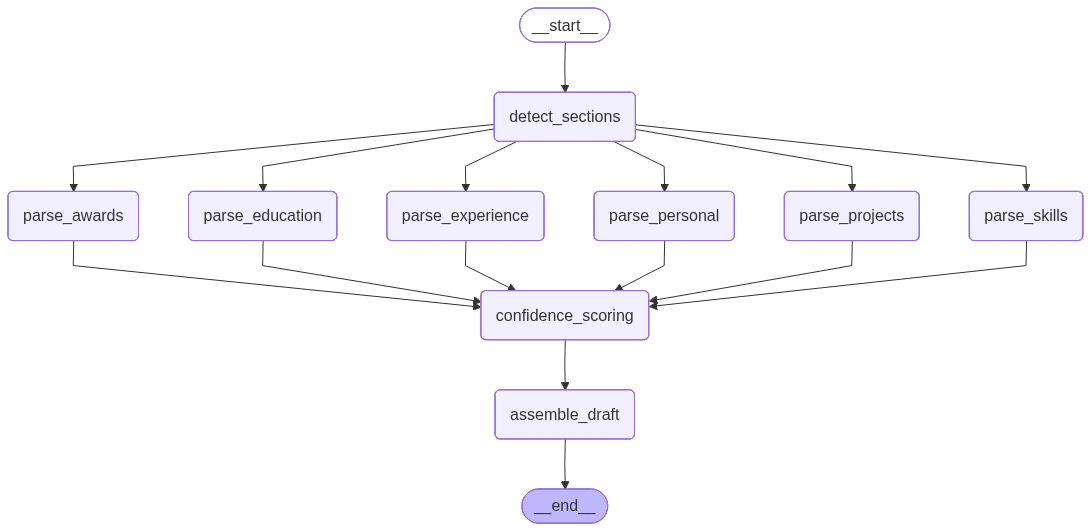

In [ ]:
app